In [ ]:
# 

## Import Libraries

In [1]:
# Import libraries
import boto3
from botocore import UNSIGNED
from botocore.client import Config
from botocore.handlers import disable_signing
import numpy as np
import pandas as pd
import networkx as nx
import itertools
import matplotlib.pyplot as plt
import time
import pickle
import re
import io
import math
import copy
from tqdm.notebook import trange, tqdm

In [207]:
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
s3 = boto3.resource('s3')
s3.meta.client.meta.events.register('choose-signer.s3.*',disable_signing)

bucket='ln-strategy-data'

decisions_load = s3.Object(bucket_name=bucket, key='full_decisions_df.csv').get()
full_decisions_df=pd.read_csv(io.BytesIO(decisions_load['Body'].read()))

In [200]:
# graph0_load  = s3.Object(bucket_name=bucket, key='graph_snapshots/1587447789_connected/505149.gpickle').get()
graph0_load  = s3.Object(bucket_name=bucket, key='graph_snapshots/1587447789_connected/505149.gpickle').get()
graph0 = pickle.loads(graph0_load['Body'].read())

In [202]:
graph0.nodes()

NodeView((6038, 5314))

In [203]:
graph0.edges()

EdgeView([(6038, 5314)])

In [90]:
extraction_id=1587447789
graph_keys = [obj.key 
        for obj in s3.Bucket(name=bucket).objects.all()
        if re.match(".*"+str(extraction_id)+"_connected/.*\.gpickle",obj.key)]

In [ ]:
graph_keys

In [75]:
X_train.shape

(57963, 12)

In [3]:
full_decisions_df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'short_channel_id', 'open_block',
       'open_transaction', 'address', 'close_block', 'close_transaction',
       'node0', 'node1', 'satoshis', 'last_seen', 'open_time', 'open_fee',
       'close_time', 'close_fee', 'last_update', 'close_type',
       'close_htlc_count', 'close_balance_a', 'close_balance_b', 'dec_id',
       'node0_id', 'node1_id', 'node_pair', 'age_n0_open_norm_rank',
       'age_n1_open_norm_rank', 'age_n0_close_norm_rank',
       'age_n1_close_norm_rank', 'betweeness_curr_aprox_n0_open_norm_rank',
       'betweeness_curr_aprox_n1_open_norm_rank',
       'betweeness_curr_aprox_n0_close_norm_rank',
       'betweeness_curr_aprox_n1_close_norm_rank',
       'capacity_n0_open_norm_rank', 'capacity_n1_open_norm_rank',
       'capacity_n0_close_norm_rank', 'capacity_n1_close_norm_rank',
       'capacity_growth_n0_open_norm_rank',
       'capacity_growth_n1_open_norm_rank',
       'capacity_growth_n0_close_norm_rank',
       'capacity_g

In [5]:
full_decisions_df.isnull().sum()

Unnamed: 0                                      0
Unnamed: 0.1                                    0
short_channel_id                                0
open_block                                      0
open_transaction                                0
address                                         0
close_block                                 34121
close_transaction                           34121
node0                                           0
node1                                           0
satoshis                                        0
last_seen                                       0
open_time                                       0
open_fee                                        0
close_time                                  34121
close_fee                                   34121
last_update                                 16956
close_type                                  35654
close_htlc_count                            35654
close_balance_a                             35654


In [4]:
open_columns = ['short_channel_id','open_block','node0_id', 'node1_id', 'satoshis', 'open_fee','age_n0_open_norm_rank',
       'age_n1_open_norm_rank', 'betweeness_curr_aprox_n0_open_norm_rank',
       'betweeness_curr_aprox_n1_open_norm_rank',
       'capacity_n0_open_norm_rank', 'capacity_n1_open_norm_rank',
       'capacity_growth_n0_open_norm_rank',
       'capacity_growth_n1_open_norm_rank','channels_n0_open_norm_rank',
       'channels_n1_open_norm_rank', 'closeness_approx_rank_n0_open_norm_rank',
       'closeness_approx_rank_n1_open_norm_rank']
open_df = full_decisions_df.filter(open_columns)

In [5]:
open_df.head()

,short_channel_id,open_block,node0_id,node1_id,satoshis,open_fee,age_n0_open_norm_rank,age_n1_open_norm_rank,betweeness_curr_aprox_n0_open_norm_rank,betweeness_curr_aprox_n1_open_norm_rank,capacity_n0_open_norm_rank,capacity_n1_open_norm_rank,capacity_growth_n0_open_norm_rank,capacity_growth_n1_open_norm_rank,channels_n0_open_norm_rank,channels_n1_open_norm_rank,closeness_approx_rank_n0_open_norm_rank,closeness_approx_rank_n1_open_norm_rank
0,617297x720x0,617297,5161,7141,1000000,154,0.036720,0.662149,0.052707,0.022700,0.106011,0.005603,0.661339,-0.000250,0.172872,0.031028,0.983718,0.860247
1,617295x550x0,617295,135,7083,95675,4325,0.565990,0.000045,0.068319,0.000008,0.066994,0.000062,0.015602,0.000468,NaN,NaN,0.975678,0.454293
2,617295x1743x1,617295,7524,1232,500000,443,0.089714,0.685791,0.008368,0.048892,0.009225,0.107460,0.006130,0.056292,NaN,NaN,0.949207,0.991516
3,617294x894x0,617294,2205,7083,95675,4325,0.513273,0.000027,0.006075,0.000355,0.017337,0.000046,0.001786,0.000351,NaN,NaN,0.937162,0.470932
4,617292x63x0,617292,7083,6270,95675,4324,0.000018,0.598464,0.000008,0.202672,0.000031,0.387552,0.000234,-0.120011,NaN,NaN,0.376379,0.988756


In [14]:
# Missing values
open_df.isnull().sum()

short_channel_id                            0
open_block                                  0
node0_id                                    0
node1_id                                    0
satoshis                                    0
open_fee                                    0
age_n0_open_norm_rank                       7
age_n1_open_norm_rank                       7
betweeness_curr_aprox_n0_open_norm_rank     7
betweeness_curr_aprox_n1_open_norm_rank     7
capacity_n0_open_norm_rank                  7
capacity_n1_open_norm_rank                  7
capacity_growth_n0_open_norm_rank           7
capacity_growth_n1_open_norm_rank           7
channels_n0_open_norm_rank                 22
channels_n1_open_norm_rank                 22
closeness_approx_rank_n0_open_norm_rank     7
closeness_approx_rank_n1_open_norm_rank     7
dtype: int64

In [15]:
len(open_df)

72476

In [6]:
open_df.dropna(inplace = True)
len(open_df)

72454

In [7]:
X = open_df.drop(labels =['short_channel_id','open_block','node0_id', 'node1_id', 'satoshis', 'open_fee'], axis =1)

In [71]:
X.head()

,age_n0_open_norm_rank,age_n1_open_norm_rank,betweeness_curr_aprox_n0_open_norm_rank,betweeness_curr_aprox_n1_open_norm_rank,capacity_n0_open_norm_rank,capacity_n1_open_norm_rank,capacity_growth_n0_open_norm_rank,capacity_growth_n1_open_norm_rank,channels_n0_open_norm_rank,channels_n1_open_norm_rank,closeness_approx_rank_n0_open_norm_rank,closeness_approx_rank_n1_open_norm_rank,age_diff_open,channel_diff_open,bet_diff_open,closeness_diff_open,capacity_diff_open,growth_diff_open
0,0.036720,0.662149,5.270711e-02,0.022700,0.106011,0.005603,0.661339,-0.000250,0.172872,0.031028,0.983718,0.860247,0.625429,0.141844,0.030007,0.123471,0.100407,0.661589
10,0.003344,0.573025,6.612156e-05,0.058979,0.000059,0.059653,0.000448,0.003720,0.007092,0.227837,0.705347,0.966929,0.569681,0.220745,0.058913,0.261582,0.059594,0.003272
11,0.000009,0.754706,3.248539e-05,0.031048,0.000031,0.085135,0.000234,-0.006180,0.001773,0.129433,0.241699,0.974934,0.754697,0.127660,0.031016,0.733235,0.085104,0.006414
12,0.380795,0.000000,1.403778e-03,0.000000,0.005139,0.000000,0.000920,0.000000,0.014184,0.000000,0.894494,0.000000,0.380795,0.014184,0.001404,0.894494,0.005139,0.000920
13,0.000232,0.896458,6.581404e-15,0.687423,0.000016,1.000000,0.000123,0.224461,0.000887,0.735816,0.583382,0.996093,0.896226,0.734929,0.687423,0.412711,0.999984,0.224337


In [41]:
corr = X.corr()
corr

,age_n0_open_norm_rank,age_n1_open_norm_rank,betweeness_curr_aprox_n0_open_norm_rank,betweeness_curr_aprox_n1_open_norm_rank,capacity_n0_open_norm_rank,capacity_n1_open_norm_rank,capacity_growth_n0_open_norm_rank,capacity_growth_n1_open_norm_rank,channels_n0_open_norm_rank,channels_n1_open_norm_rank,closeness_approx_rank_n0_open_norm_rank,closeness_approx_rank_n1_open_norm_rank
age_n0_open_norm_rank,1.000000,-0.180539,0.389719,-0.184444,0.281454,-0.175576,-0.035631,-0.082403,0.463904,-0.205130,0.540057,-0.203395
age_n1_open_norm_rank,-0.180539,1.000000,-0.187071,0.400858,-0.157111,0.334275,-0.058224,0.024129,-0.212689,0.482077,-0.180334,0.558591
betweeness_curr_aprox_n0_open_norm_rank,0.389719,-0.187071,1.000000,-0.174519,0.715732,-0.182991,0.316942,-0.086273,0.767081,-0.213038,0.377425,-0.234625
betweeness_curr_aprox_n1_open_norm_rank,-0.184444,0.400858,-0.174519,1.000000,-0.165210,0.770438,-0.073306,0.366764,-0.221388,0.815421,-0.231401,0.398813
capacity_n0_open_norm_rank,0.281454,-0.157111,0.715732,-0.165210,1.000000,-0.142974,0.494435,-0.053833,0.530494,-0.204895,0.411392,-0.163335
capacity_n1_open_norm_rank,-0.175576,0.334275,-0.182991,0.770438,-0.142974,1.000000,-0.049898,0.497533,-0.235213,0.656803,-0.185880,0.448278
capacity_growth_n0_open_norm_rank,-0.035631,-0.058224,0.316942,-0.073306,0.494435,-0.049898,1.000000,0.009727,0.200291,-0.091662,0.216460,-0.042520
capacity_growth_n1_open_norm_rank,-0.082403,0.024129,-0.086273,0.366764,-0.053833,0.497533,0.009727,1.000000,-0.112278,0.276748,-0.079329,0.223275
channels_n0_open_norm_rank,0.463904,-0.212689,0.767081,-0.221388,0.530494,-0.235213,0.200291,-0.112278,1.000000,-0.260825,0.450952,-0.256823
channels_n1_open_norm_rank,-0.205130,0.482077,-0.213038,0.815421,-0.204895,0.656803,-0.091662,0.276748,-0.260825,1.000000,-0.247344,0.478169


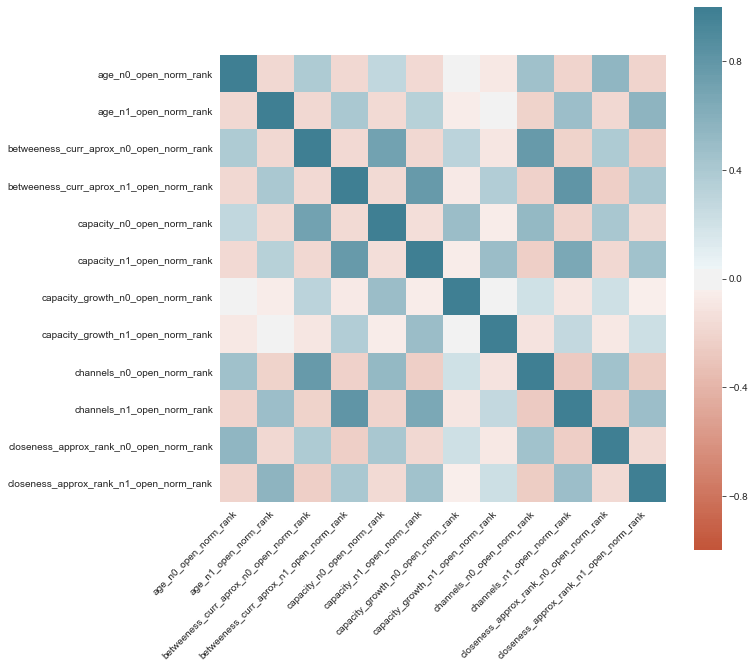

In [69]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [55]:
X['age_diff_open'] = np.abs(X['age_n0_open_norm_rank'] - X['age_n1_open_norm_rank'])
X['channel_diff_open'] = np.abs(X['channels_n0_open_norm_rank'] - X['channels_n1_open_norm_rank'])
X['bet_diff_open'] = np.abs(X['betweeness_curr_aprox_n0_open_norm_rank'] - X['betweeness_curr_aprox_n1_open_norm_rank'])
X['closeness_diff_open'] = np.abs(X['closeness_approx_rank_n0_open_norm_rank'] - X['closeness_approx_rank_n1_open_norm_rank'])
X['capacity_diff_open'] = np.abs(X['capacity_n0_open_norm_rank'] - X['capacity_n1_open_norm_rank'])
X['growth_diff_open'] = np.abs(X['capacity_growth_n0_open_norm_rank'] - X['capacity_growth_n1_open_norm_rank'])


# plt.hist(X.age_n0_open_norm_rank, bins = 50);

In [239]:
X['age_avg_open'] = np.mean(X[['age_n0_open_norm_rank','age_n1_open_norm_rank']],axis =1)
X['channel_avg_open'] = np.mean(X[['channels_n0_open_norm_rank','channels_n1_open_norm_rank']],axis=1)
X['bet_avg_open'] = np.mean(X[['betweeness_curr_aprox_n0_open_norm_rank','betweeness_curr_aprox_n1_open_norm_rank']], axis=1)
X['closeness_avg_open'] = np.mean(X[['closeness_approx_rank_n0_open_norm_rank','closeness_approx_rank_n1_open_norm_rank']], axis=1)
X['capacity_avg_open'] = np.mean(X[['capacity_n0_open_norm_rank','capacity_n1_open_norm_rank']], axis=1)
X['growth_avg_open'] = np.mean(X[['capacity_growth_n0_open_norm_rank','capacity_growth_n1_open_norm_rank']], axis=1)

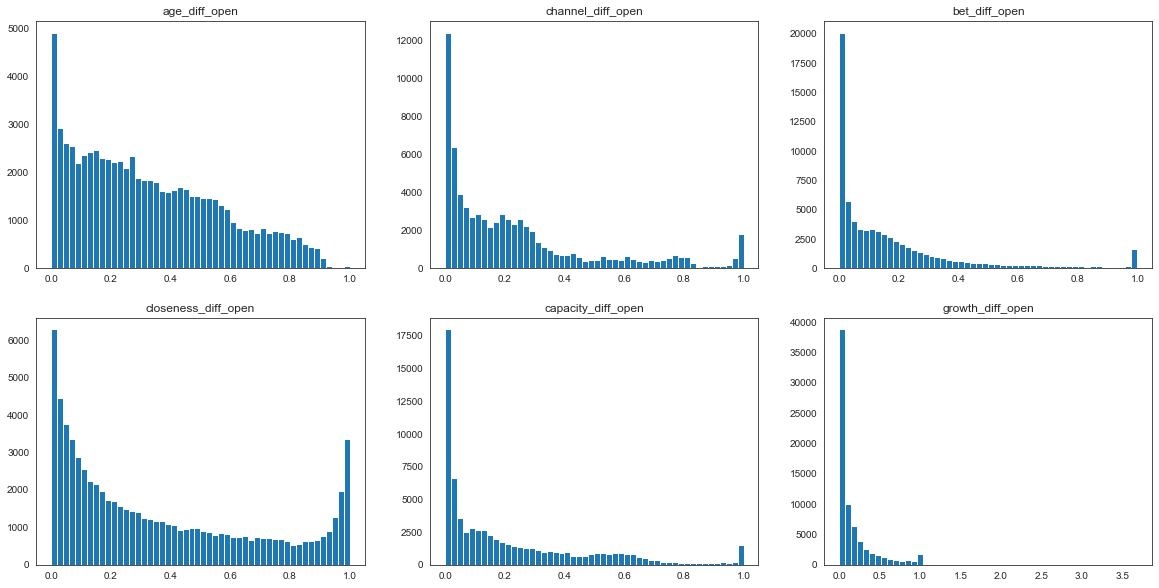

In [273]:
diffs = ['age_diff_open','channel_diff_open','bet_diff_open', 'closeness_diff_open', 'capacity_diff_open', 'growth_diff_open']
plt.figure(figsize=(20,10))
for i in range(6):
    plt.subplot(2,3, i+1)
    plt.hist(X[diffs[i]], bins = 50)
    plt.title(diffs[i]);

In [83]:
diff_df = X.filter(diffs)

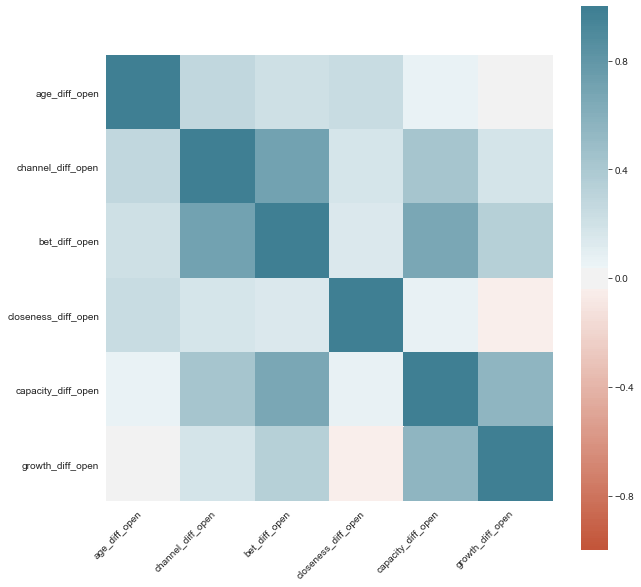

In [84]:
diff_corr = diff_df.corr()
plt.figure(figsize=(10,10))
ax = sns.heatmap(
    diff_corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [240]:
avg_diff_columns = ['age_avg_open','channel_avg_open','bet_avg_open', 'closeness_avg_open', 
                   'capacity_avg_open', 'growth_avg_open', 'age_diff_open','channel_diff_open',
                   'bet_diff_open', 'closeness_diff_open', 'capacity_diff_open', 'growth_diff_open']

avg_diff_df = X.filter(avg_diff_columns)

In [241]:
avg_diff_df.head()

,age_avg_open,channel_avg_open,bet_avg_open,closeness_avg_open,capacity_avg_open,growth_avg_open,age_diff_open,channel_diff_open,bet_diff_open,closeness_diff_open,capacity_diff_open,growth_diff_open
0,0.349434,0.101950,0.037704,0.921983,0.055807,0.330545,0.625429,0.141844,0.030007,0.123471,0.100407,0.661589
10,0.288184,0.117465,0.029523,0.836138,0.029856,0.002084,0.569681,0.220745,0.058913,0.261582,0.059594,0.003272
11,0.377358,0.065603,0.015540,0.608316,0.042583,-0.002973,0.754697,0.127660,0.031016,0.733235,0.085104,0.006414
12,0.190398,0.007092,0.000702,0.447247,0.002569,0.000460,0.380795,0.014184,0.001404,0.894494,0.005139,0.000920
13,0.448345,0.368351,0.343712,0.789738,0.500008,0.112292,0.896226,0.734929,0.687423,0.412711,0.999984,0.224337


In [9]:
train_idx = np.random.choice(range(len(X)), int(len(X) * .8), replace=False)
test_idx = list(set(range(len(X))) - set(list(train_idx))) 
X_train = X.iloc[train_idx]
X_test = X.iloc[test_idx] # What is iloc again? how is it different from without it?

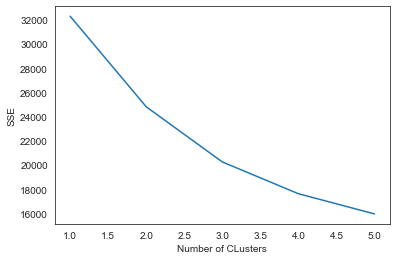

In [242]:
# Cluster on avg_diff_df
avg_diff_train = avg_diff_df.iloc[train_idx]
avg_diff_test = avg_diff_df.iloc[test_idx]

from sklearn.cluster import KMeans

n_clusters = np.arange(1, 6)
sse = []
for n in n_clusters:
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(avg_diff_train)
    sse.append(kmeans.inertia_)

plt.plot(n_clusters, sse)
plt.xlabel('Number of CLusters')
plt.ylabel('SSE');

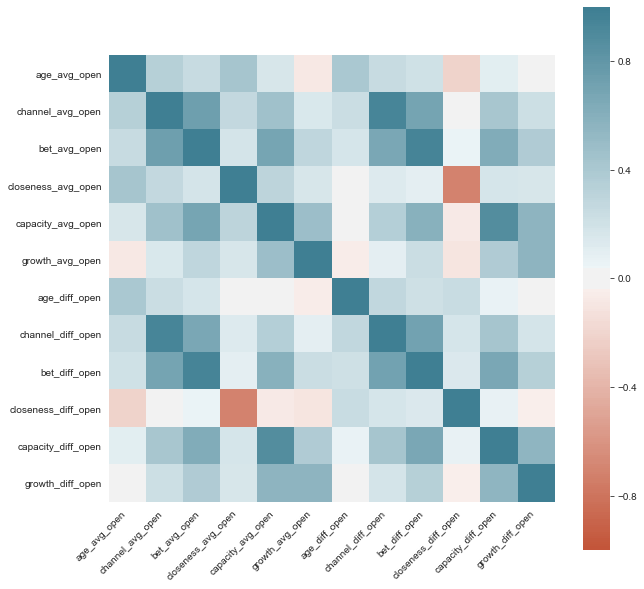

In [260]:
avg_diff_corr = avg_diff_df.corr()
plt.figure(figsize=(10,10))
ax = sns.heatmap(
    avg_diff_corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [268]:
avg_diff_corr

,age_avg_open,channel_avg_open,bet_avg_open,closeness_avg_open,capacity_avg_open,growth_avg_open,age_diff_open,channel_diff_open,bet_diff_open,closeness_diff_open,capacity_diff_open,growth_diff_open
age_avg_open,1.000000,0.337927,0.254981,0.431266,0.170356,-0.081645,0.404480,0.256469,0.198754,-0.214943,0.102444,0.006686
channel_avg_open,0.337927,1.000000,0.729942,0.268449,0.463483,0.156214,0.235054,0.939175,0.693583,0.022158,0.423101,0.220672
bet_avg_open,0.254981,0.729942,1.000000,0.186778,0.680079,0.290416,0.176846,0.669030,0.952624,0.047968,0.639264,0.374544
closeness_avg_open,0.431266,0.268449,0.186778,1.000000,0.300033,0.171019,-0.019088,0.125825,0.097243,-0.712199,0.179087,0.171445
capacity_avg_open,0.170356,0.463483,0.680079,0.300033,1.000000,0.477751,0.007671,0.356852,0.589353,-0.074418,0.876907,0.559828
growth_avg_open,-0.081645,0.156214,0.290416,0.171019,0.477751,1.000000,-0.049444,0.086610,0.228533,-0.104574,0.368632,0.558196
age_diff_open,0.404480,0.235054,0.176846,-0.019088,0.007671,-0.049444,1.000000,0.282426,0.212852,0.247993,0.065885,-0.014138
channel_diff_open,0.256469,0.939175,0.669030,0.125825,0.356852,0.086610,0.282426,1.000000,0.714206,0.173454,0.432444,0.182351
bet_diff_open,0.198754,0.693583,0.952624,0.097243,0.589353,0.228533,0.212852,0.714206,1.000000,0.146665,0.665449,0.345125
closeness_diff_open,-0.214943,0.022158,0.047968,-0.712199,-0.074418,-0.104574,0.247993,0.173454,0.146665,1.000000,0.072043,-0.044829


### K-means Clustering

In [243]:
kmeans = KMeans(n_clusters= 3, random_state = 123)
kmeans.fit(avg_diff_train)
y_kmeans = kmeans.predict(avg_diff_train)
print(kmeans.inertia_)
clusters3 = copy.deepcopy(avg_diff_train)
clusters3['cluster_label'] = y_kmeans
clusters3.head(5)

20253.391669910405


,age_avg_open,channel_avg_open,bet_avg_open,closeness_avg_open,capacity_avg_open,growth_avg_open,age_diff_open,channel_diff_open,bet_diff_open,closeness_diff_open,capacity_diff_open,growth_diff_open,cluster_label
38309,0.262336,0.165827,0.129187,0.654635,0.349666,0.320947,0.167601,0.323258,0.256711,0.646597,0.682121,0.619123,2
68455,0.279855,0.050847,0.011397,0.891260,0.009942,0.046919,0.539965,0.022599,0.004357,0.023928,0.001727,0.071528,0
26088,0.379865,0.289009,0.229047,0.971019,0.137863,0.011628,0.123678,0.534838,0.449665,0.048892,0.232558,0.024381,0
48520,0.332604,0.151551,0.268589,0.919967,0.504416,0.502269,0.663147,0.262530,0.390926,0.135122,0.991168,0.995463,2
48421,0.137073,0.119928,0.060056,0.736475,0.280152,0.139014,0.271539,0.235084,0.119944,0.468742,0.559856,0.277580,0


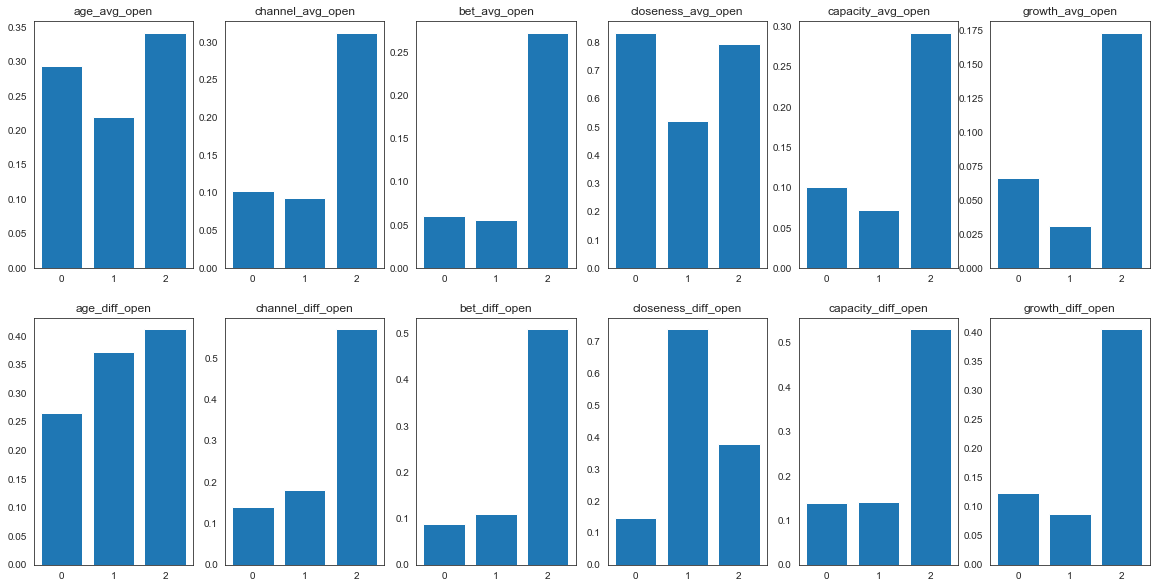

In [259]:
avg_diff_columns = avg_diff_df.columns
plt.figure(figsize=(20,10))
for i in range(len(avg_diff_columns)):
    plt.subplot(2,6, i+1)
    plt.bar(clusters3.groupby('cluster_label')[avg_diff_columns[i]].mean().index, clusters3.groupby('cluster_label')[avg_diff_columns[i]].mean());
    plt.title(avg_diff_columns[i]);

24812.29252437712


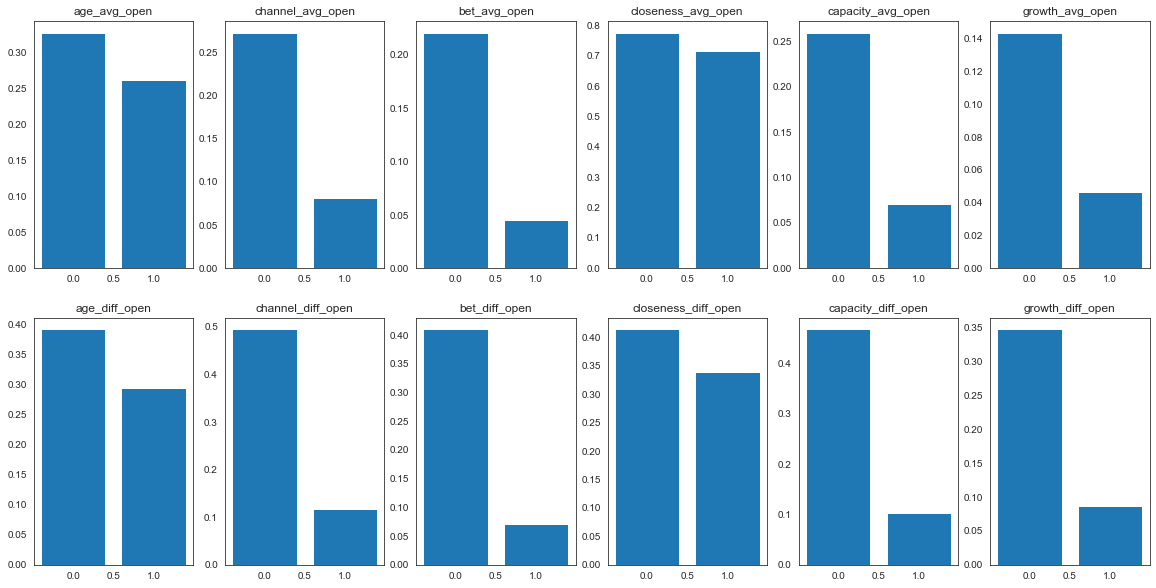

In [267]:
kmeans2 = KMeans(n_clusters= 2, random_state = 123)
kmeans2.fit(avg_diff_train)
y_kmeans2 = kmeans2.predict(avg_diff_train)
print(kmeans2.inertia_)
clusters2 = copy.deepcopy(avg_diff_train)
clusters2['cluster_label'] = y_kmeans2

plt.figure(figsize=(20,10))
for i in range(len(avg_diff_columns)):
    plt.subplot(2,6, i+1)
    plt.bar(clusters2.groupby('cluster_label')[avg_diff_columns[i]].mean().index, clusters2.groupby('cluster_label')[avg_diff_columns[i]].mean());
    plt.title(avg_diff_columns[i]);

In [265]:
kmeans4 = KMeans(n_clusters= 4, random_state = 123)
kmeans4.fit(avg_diff_train)
y_kmeans4 = kmeans4.predict(avg_diff_train)
print(kmeans4.inertia_)
clusters4 = copy.deepcopy(avg_diff_train)
clusters4['cluster_label'] = y_kmeans4

17625.662503645388


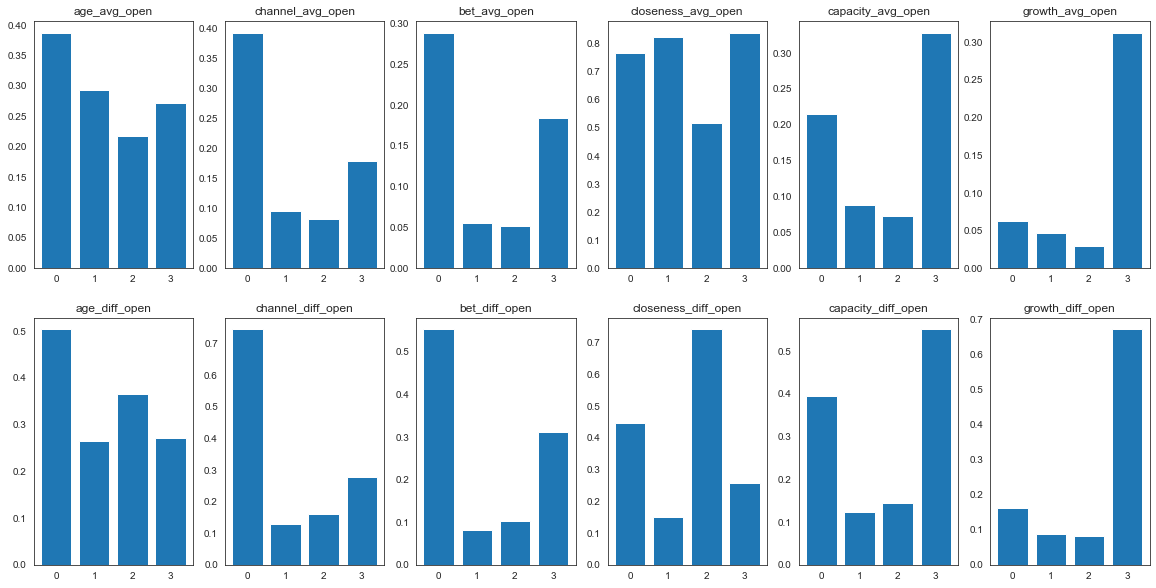

In [266]:
avg_diff_columns = avg_diff_df.columns
plt.figure(figsize=(20,10))
for i in range(len(avg_diff_columns)):
    plt.subplot(2,6, i+1)
    plt.bar(clusters4.groupby('cluster_label')[avg_diff_columns[i]].mean().index, clusters4.groupby('cluster_label')[avg_diff_columns[i]].mean());
    plt.title(avg_diff_columns[i]);

Text(0, 0.5, 'SSE')

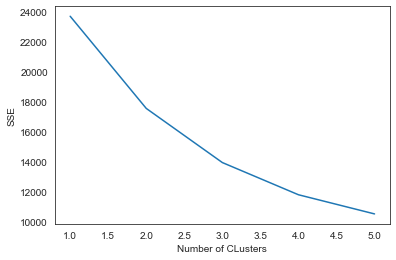

In [66]:
#Cluster only on diff columns

n_clusters = np.arange(1, 6)
sse_diff = []
for n in n_clusters:
    kmeans_diff = KMeans(n_clusters=n)
    kmeans_diff.fit(diff_train)
    sse_diff.append(kmeans_diff.inertia_)

plt.plot(n_clusters, sse_diff)
plt.xlabel('Number of CLusters')
plt.ylabel('SSE');

In [81]:
kmeans_diff = KMeans(n_clusters= 3, random_state = 456)
kmeans_diff.fit(diff_train)
y_kmeans_diff = kmeans_diff.predict(diff_train)
print(kmeans_diff.inertia_)
diff_clusters3 = copy.deepcopy(diff_train)
diff_clusters3['cluster_label'] = y_kmeans_diff
diff_clusters3.head(20)

13945.98467834022


,age_diff_open,channel_diff_open,bet_diff_open,closeness_diff_open,capacity_diff_open,growth_diff_open,cluster_label
38309,0.167601,0.323258,0.256711,0.646597,0.682121,0.619123,2
68455,0.539965,0.022599,0.004357,0.023928,0.001727,0.071528,0
26088,0.123678,0.534838,0.449665,0.048892,0.232558,0.024381,0
48520,0.663147,0.262530,0.390926,0.135122,0.991168,0.995463,2
48421,0.271539,0.235084,0.119944,0.468742,0.559856,0.277580,2
19697,0.507343,0.966436,0.830988,0.138472,0.176435,0.092566,2
37330,0.189879,0.132736,0.044857,0.840168,0.190944,0.281830,1
41566,0.115916,0.757812,0.754454,0.043884,0.669738,0.348123,2
24629,0.016757,0.094675,0.174249,0.043591,0.001253,0.004073,0
51753,0.186932,0.217784,0.106063,0.224129,0.398666,0.238102,0


(array([45716.,  8189.,  7763.,  3080.,  2107.,  1358.,  1199.,  1148.,
          782.,  1112.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

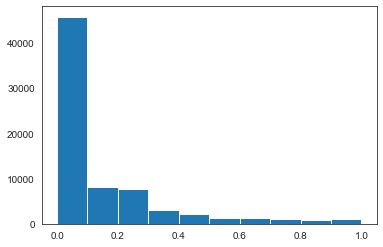

In [60]:
plt.hist(X['channels_n1_open_norm_rank']) # tag each node with label small, intermediate, big

(array([47493.,  7560.,  6849.,  2844.,  1244.,  1077.,  1162.,  1576.,
          750.,  1899.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

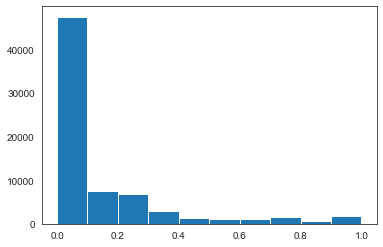

In [61]:
plt.hist(X['channels_n0_open_norm_rank'])

Text(0, 0.5, 'SSE')

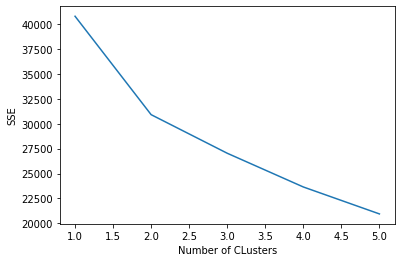

In [12]:
n_clusters = np.arange(1, 6)
sse = []
for n in n_clusters:
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(X_train)
    sse.append(kmeans.inertia_)

plt.plot(n_clusters, sse)
plt.xlabel('Number of CLusters')
plt.ylabel('SSE')

In [14]:
from sklearn import decomposition
from sklearn.decomposition import PCA

pca = decomposition.PCA(n_components = 3)
train_pca = pca.fit_transform(X_train)
print("The amount of variance explained by the projected data is {}%".format(np.sum(pca.explained_variance_ratio_)))
print("Dimension of original data {}".format(X_train.shape))
print("Dimension of projected data reprentation {}".format(train_pca.shape))

The amount of variance explained by the projected data is 0.6470429052883233%
Dimension of original data (57963, 12)
Dimension of projected data reprentation (57963, 3)


In [45]:
pca.components_

array([[-0.29340756,  0.31864694, -0.20856982,  0.26651066, -0.19945029,
         0.31612794, -0.08581338,  0.1606631 , -0.28985506,  0.29797445,
        -0.39656525,  0.44145696],
       [ 0.33371817,  0.25219054,  0.21332228,  0.20669727,  0.23880737,
         0.27414541,  0.13668311,  0.17408881,  0.26940883,  0.21145373,
         0.5281839 ,  0.39919429],
       [ 0.00975327,  0.4603444 , -0.07174877, -0.27804352, -0.05686137,
        -0.40507395, -0.04314198, -0.55988898, -0.04994674, -0.15272749,
         0.10392478,  0.43157395]])

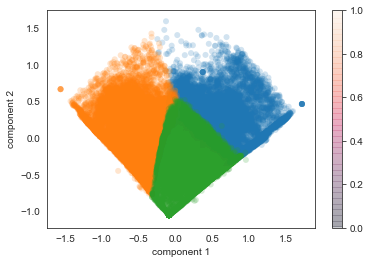

In [33]:
# Plot the clusters from the perspectives of the first two principal components in a 2d graph
for i in np.unique(kmeans.labels_):
    plt.scatter(train_pca[kmeans.labels_ == i, 0], train_pca[kmeans.labels_ == i, 1], edgecolor='none', alpha=0.2, 
                cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

<Figure size 480x480 with 0 Axes>

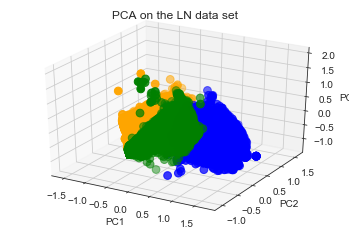

In [37]:
# Plot the clusters from the perspectives of the first three principal components in 3d graph
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_style("white")
my_dpi=96
plt.figure(figsize=(480/my_dpi, 480/my_dpi), dpi=my_dpi)

# Store results of PCA in a data frame
# result= pd.DataFrame(pca.transform(X_train), columns=['PCA%i' % i for i in range(3)], index=X_train.index)
 
# Plot initialisation
colors = ['blue','orange','green']
fig = plt.figure()
ax = fig.gca(projection='3d')
for i in np.unique(kmeans.labels_):
    ax.scatter(train_pca[kmeans.labels_ == i, 0], train_pca[kmeans.labels_ == i, 1], train_pca[kmeans.labels_ == i, 2],
               c=colors[i], cmap="Set2_r", s=60)
# ax.scatter(xs, ys, zs, c='r', marker='o')
# ax.scatter(xt, yt, zt, c='b', marker='^')
 
# make simple, bare axis lines through space:
# xAxisLine = ((min(result['PCA0']), max(result['PCA0'])), (0, 0), (0,0))
# ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
# yAxisLine = ((0, 0), (min(result['PCA1']), max(result['PCA1'])), (0,0))
# ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
# zAxisLine = ((0, 0), (0,0), (min(result['PCA2']), max(result['PCA2'])))
# ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')
 
# label the axes
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PCA on the LN data set")
plt.show();


### Dataframe of Channels that are Closed

In [128]:
close_df = full_decisions_df[full_decisions_df['close_block'].notnull()]
print('How many closes: ',len(close_df))
close_df.head()

How many closes:  38355


,Unnamed: 0,Unnamed: 0.1,short_channel_id,open_block,open_transaction,address,close_block,close_transaction,node0,node1,...,capacity_growth_n0_close_norm_rank,capacity_growth_n1_close_norm_rank,channels_n0_open_norm_rank,channels_n1_open_norm_rank,closeness_approx_rank_n0_open_norm_rank,closeness_approx_rank_n1_open_norm_rank,closeness_approx_rank_n0_close_norm_rank,closeness_approx_rank_n1_close_norm_rank,channels_n0_close_norm_rank,channels_n1_close_norm_rank
278,278,72178,617118x511x1,617118,2a18821070d2e46d20e1d94b3dfa2dae894ec78755749f...,bc1q5czf4zz7ut8acvx8dm6q8ffse8yqq7tv86n09pt6xe...,617245.0,26faabb331ef297008d7684e09b8ba530be41457a9488b...,039edc94987c8f3adc28dab455efc00dea876089a120f5...,03b27c85b6359c5c688a900f6cc271cb47945d76e1c391...,...,0.073384,0.057292,0.250667,0.000889,0.990977,0.458562,0.982420,0.300888,0.251779,0.000890
347,347,72112,617078x1074x1,617078,aa58b7004d09169797cf1d22d777bf9c360038a5203de3...,bc1q2pjwaq6wzuwrdgsk2s2t27vn56xgx9neczukz2au5g...,617186.0,e2578e1c85904ca2324d238f1da0df3e700adfc5e1fb09...,0289d4c6dbf647db4c24decc6d2e50d5d1d0536fd15496...,02c12b5459cf107ee0440cae41902f1189db50fa003a07...,...,0.000658,0.114918,0.007993,0.087034,0.820601,0.971561,0.802935,0.977850,0.009795,0.087266
348,348,72111,617078x1073x0,617078,e8510183e69482b8787fbc8a9849b4799dbb77f1a735ec...,bc1qdmyfvtzlqnyjvczusx3tv9332t9rf5k6axl56yff65...,617186.0,c87ace7dde238ffb13158b37fa25ff5da7602268cd2f03...,0289d4c6dbf647db4c24decc6d2e50d5d1d0536fd15496...,030043d0a2cfb69d80867094eb030f8abde7a5dc36e1a0...,...,0.000658,-0.008398,0.007993,0.005329,0.820601,0.742814,0.802935,0.788087,0.009795,0.006233
349,349,72110,617078x1072x0,617078,81b09c2cd9596a61863533e7cdeac76141a63c445965e8...,bc1qn9e0tghjs7aj9mkferducy0zvezykmvu28pdp0glu6...,617186.0,a58998f8096668624e6c2317c4274f8f73916f6142d6d5...,0289d4c6dbf647db4c24decc6d2e50d5d1d0536fd15496...,03bb88ccc444534da7b5b64b4f7b15e1eccb18e102db0e...,...,0.000658,0.116228,0.007993,0.539964,0.820601,0.992634,0.802935,0.994270,0.009795,0.540516
350,350,72109,617078x1071x0,617078,a5e42f74802d63ba6d57ce0f7a5edeba76e5f21a990557...,bc1qg7pu3y76lducfxtpxtff84suwhk20v5luhxsed97m6...,617187.0,e555009d6b51e50318da6801d4e8788d4b956991a49659...,021802799027508e8a8bf9a0ab96ea78a6a995926a0b13...,0289d4c6dbf647db4c24decc6d2e50d5d1d0536fd15496...,...,0.000261,0.000431,0.042629,0.007993,0.902019,0.820601,0.901865,0.531963,0.043633,0.004452


In [129]:
close_columns = ['short_channel_id','open_block','close_block','node0_id', 'node1_id', 'satoshis', 'open_fee','age_n0_open_norm_rank',
       'age_n1_open_norm_rank', 'betweeness_curr_aprox_n0_open_norm_rank','betweeness_curr_aprox_n1_open_norm_rank',
       'capacity_n0_open_norm_rank', 'capacity_n1_open_norm_rank','capacity_growth_n0_open_norm_rank',
       'capacity_growth_n1_open_norm_rank','channels_n0_open_norm_rank','channels_n1_open_norm_rank', 
       'closeness_approx_rank_n0_open_norm_rank','closeness_approx_rank_n1_open_norm_rank', 'age_n0_close_norm_rank',
       'age_n1_close_norm_rank', 'betweeness_curr_aprox_n0_close_norm_rank','betweeness_curr_aprox_n1_close_norm_rank',
       'capacity_n0_close_norm_rank', 'capacity_n1_close_norm_rank','capacity_growth_n0_close_norm_rank',
       'capacity_growth_n1_close_norm_rank','channels_n0_close_norm_rank','channels_n1_close_norm_rank', 
       'closeness_approx_rank_n0_close_norm_rank','closeness_approx_rank_n1_close_norm_rank']
close_df = close_df.filter(close_columns)
close_df.head()

,short_channel_id,open_block,close_block,node0_id,node1_id,satoshis,open_fee,age_n0_open_norm_rank,age_n1_open_norm_rank,betweeness_curr_aprox_n0_open_norm_rank,...,betweeness_curr_aprox_n0_close_norm_rank,betweeness_curr_aprox_n1_close_norm_rank,capacity_n0_close_norm_rank,capacity_n1_close_norm_rank,capacity_growth_n0_close_norm_rank,capacity_growth_n1_close_norm_rank,channels_n0_close_norm_rank,channels_n1_close_norm_rank,closeness_approx_rank_n0_close_norm_rank,closeness_approx_rank_n1_close_norm_rank
278,617118x511x1,617118,617245.0,1392,5286,11000000,1694,0.596447,0.001331,0.449403,...,0.126052,1.867708e-12,0.364293,0.007223,0.073384,0.057292,0.251779,0.000890,0.982420,0.300888
347,617078x1074x1,617078,617186.0,994,6065,20000,4582,0.001447,0.548840,0.000076,...,0.000133,7.790642e-02,0.000081,0.179109,0.000658,0.114918,0.009795,0.087266,0.802935,0.977850
348,617078x1073x0,617078,617186.0,994,7088,20000,4582,0.001447,0.894806,0.000076,...,0.000133,1.257137e-03,0.000081,0.003813,0.000658,-0.008398,0.009795,0.006233,0.802935,0.788087
349,617078x1072x0,617078,617186.0,994,4249,20000,4582,0.001447,0.756815,0.000076,...,0.000133,2.132576e-01,0.000081,0.192646,0.000658,0.116228,0.009795,0.540516,0.802935,0.994270
350,617078x1071x0,617078,617187.0,5864,994,20000,4581,0.521233,0.001447,0.003057,...,0.003704,4.946882e-05,0.007071,0.000053,0.000261,0.000431,0.043633,0.004452,0.901865,0.531963


In [178]:
close_df['channel_age'] = close_df.close_block.astype('int') - close_df.open_block
close_df.head()

,short_channel_id,open_block,close_block,node0_id,node1_id,satoshis,open_fee,age_n0_open_norm_rank,age_n1_open_norm_rank,betweeness_curr_aprox_n0_open_norm_rank,...,betweeness_curr_aprox_n1_close_norm_rank,capacity_n0_close_norm_rank,capacity_n1_close_norm_rank,capacity_growth_n0_close_norm_rank,capacity_growth_n1_close_norm_rank,channels_n0_close_norm_rank,channels_n1_close_norm_rank,closeness_approx_rank_n0_close_norm_rank,closeness_approx_rank_n1_close_norm_rank,channel_age
278,617118x511x1,617118,617245.0,1392,5286,11000000,1694,0.596447,0.001331,0.449403,...,1.867708e-12,0.364293,0.007223,0.073384,0.057292,0.251779,0.000890,0.982420,0.300888,127
347,617078x1074x1,617078,617186.0,994,6065,20000,4582,0.001447,0.548840,0.000076,...,7.790642e-02,0.000081,0.179109,0.000658,0.114918,0.009795,0.087266,0.802935,0.977850,108
348,617078x1073x0,617078,617186.0,994,7088,20000,4582,0.001447,0.894806,0.000076,...,1.257137e-03,0.000081,0.003813,0.000658,-0.008398,0.009795,0.006233,0.802935,0.788087,108
349,617078x1072x0,617078,617186.0,994,4249,20000,4582,0.001447,0.756815,0.000076,...,2.132576e-01,0.000081,0.192646,0.000658,0.116228,0.009795,0.540516,0.802935,0.994270,108
350,617078x1071x0,617078,617187.0,5864,994,20000,4581,0.521233,0.001447,0.003057,...,4.946882e-05,0.007071,0.000053,0.000261,0.000431,0.043633,0.004452,0.901865,0.531963,109


In [180]:
close_df.dropna(inplace=True)

Text(0.5, 1.0, 'distribution of channel age')

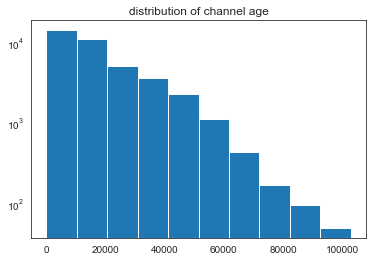

In [294]:
plt.hist(close_df.channel_age)
plt.yscale('log')
plt.title('distribution of channel age')

In [135]:
Xy_close = close_df.drop(labels =['short_channel_id','open_block','close_block','node0_id', 'node1_id', 'satoshis', 'open_fee'], axis =1)

Xy_close.corr()

,age_n0_open_norm_rank,age_n1_open_norm_rank,betweeness_curr_aprox_n0_open_norm_rank,betweeness_curr_aprox_n1_open_norm_rank,capacity_n0_open_norm_rank,capacity_n1_open_norm_rank,capacity_growth_n0_open_norm_rank,capacity_growth_n1_open_norm_rank,channels_n0_open_norm_rank,channels_n1_open_norm_rank,...,betweeness_curr_aprox_n1_close_norm_rank,capacity_n0_close_norm_rank,capacity_n1_close_norm_rank,capacity_growth_n0_close_norm_rank,capacity_growth_n1_close_norm_rank,channels_n0_close_norm_rank,channels_n1_close_norm_rank,closeness_approx_rank_n0_close_norm_rank,closeness_approx_rank_n1_close_norm_rank,channel_age
age_n0_open_norm_rank,1.000000,-0.209950,0.401833,-0.167916,0.277335,-0.147721,-0.019630,-0.062170,0.404584,-0.196229,...,-0.162728,0.231855,-0.141710,-0.010127,0.037650,0.317468,-0.187858,0.370289,-0.134974,-0.046359
age_n1_open_norm_rank,-0.209950,1.000000,-0.180816,0.404623,-0.148500,0.321524,-0.043540,0.030609,-0.217080,0.464913,...,0.389272,-0.144612,0.317517,0.037595,-0.005321,-0.214365,0.405000,-0.129273,0.414472,-0.074623
betweeness_curr_aprox_n0_open_norm_rank,0.401833,-0.180816,1.000000,-0.174077,0.714455,-0.194169,0.326117,-0.103520,0.732100,-0.210911,...,-0.175931,0.635880,-0.195056,-0.038283,0.024712,0.668606,-0.214496,0.340704,-0.120613,0.076142
betweeness_curr_aprox_n1_open_norm_rank,-0.167916,0.404623,-0.174077,1.000000,-0.180009,0.774693,-0.084323,0.397788,-0.219569,0.803043,...,0.772988,-0.176719,0.679672,0.029052,-0.064820,-0.223886,0.718326,-0.121080,0.351495,0.039914
capacity_n0_open_norm_rank,0.277335,-0.148500,0.714455,-0.180009,1.000000,-0.187067,0.516316,-0.096452,0.492303,-0.221086,...,-0.175258,0.894376,-0.187001,-0.064742,0.022005,0.459443,-0.219808,0.373834,-0.106225,-0.031726
capacity_n1_open_norm_rank,-0.147721,0.321524,-0.194169,0.774693,-0.187067,1.000000,-0.084387,0.543213,-0.245670,0.638874,...,0.712584,-0.185198,0.884256,0.031390,-0.083353,-0.247985,0.584289,-0.123420,0.407123,-0.056104
capacity_growth_n0_open_norm_rank,-0.019630,-0.043540,0.326117,-0.084323,0.516316,-0.084387,1.000000,-0.017067,0.200371,-0.106704,...,-0.077847,0.527656,-0.088395,0.112012,-0.040490,0.221495,-0.106858,0.220323,-0.003621,0.083840
capacity_growth_n1_open_norm_rank,-0.062170,0.030609,-0.103520,0.397788,-0.096452,0.543213,-0.017067,1.000000,-0.129811,0.291948,...,0.376350,-0.091072,0.514156,0.007303,0.067572,-0.133030,0.306207,-0.032095,0.233376,0.108878
channels_n0_open_norm_rank,0.404584,-0.217080,0.732100,-0.219569,0.492303,-0.245670,0.200371,-0.129811,1.000000,-0.257910,...,-0.221316,0.470871,-0.245707,-0.052740,0.036167,0.909806,-0.264368,0.406041,-0.140635,0.044962
channels_n1_open_norm_rank,-0.196229,0.464913,-0.210911,0.803043,-0.221086,0.638874,-0.106704,0.291948,-0.257910,1.000000,...,0.726062,-0.219274,0.586355,0.027636,-0.063937,-0.264286,0.905376,-0.135521,0.419896,0.035691


In [182]:
# split into train, test
close_X = close_df.drop(labels =['short_channel_id','open_block','close_block','node0_id', 'node1_id', 'satoshis', 'open_fee', 'channel_age'], axis =1)
close_y = close_df['channel_age']


In [156]:
close_X.columns

Index(['age_n0_open_norm_rank', 'age_n1_open_norm_rank',
       'betweeness_curr_aprox_n0_open_norm_rank',
       'betweeness_curr_aprox_n1_open_norm_rank', 'capacity_n0_open_norm_rank',
       'capacity_n1_open_norm_rank', 'capacity_growth_n0_open_norm_rank',
       'capacity_growth_n1_open_norm_rank', 'channels_n0_open_norm_rank',
       'channels_n1_open_norm_rank', 'closeness_approx_rank_n0_open_norm_rank',
       'closeness_approx_rank_n1_open_norm_rank', 'age_n0_close_norm_rank',
       'age_n1_close_norm_rank', 'betweeness_curr_aprox_n0_close_norm_rank',
       'betweeness_curr_aprox_n1_close_norm_rank',
       'capacity_n0_close_norm_rank', 'capacity_n1_close_norm_rank',
       'capacity_growth_n0_close_norm_rank',
       'capacity_growth_n1_close_norm_rank', 'channels_n0_close_norm_rank',
       'channels_n1_close_norm_rank',
       'closeness_approx_rank_n0_close_norm_rank',
       'closeness_approx_rank_n1_close_norm_rank'],
      dtype='object')

In [271]:
# close_X['age_diff_close'] = np.abs(close_X['age_n0_close_norm_rank'] - close_X['age_n1_close_norm_rank'])
close_X['channel_diff_close'] = np.abs(close_X['channels_n0_close_norm_rank'] - close_X['channels_n1_close_norm_rank'])
close_X['bet_diff_close'] = np.abs(close_X['betweeness_curr_aprox_n0_close_norm_rank'] - close_X['betweeness_curr_aprox_n1_close_norm_rank'])
close_X['closeness_diff_close'] = np.abs(close_X['closeness_approx_rank_n0_close_norm_rank'] - close_X['closeness_approx_rank_n1_close_norm_rank'])
close_X['capacity_diff_close'] = np.abs(close_X['capacity_n0_close_norm_rank'] - close_X['capacity_n1_close_norm_rank'])
close_X['growth_diff_close'] = np.abs(close_X['capacity_growth_n0_close_norm_rank'] - close_X['capacity_growth_n1_close_norm_rank'])

# close_X['age_avg_close'] = np.mean(close_X['age_n0_close_norm_rank'] + close_X['age_n1_close_norm_rank'])
close_X['channel_avg_close'] = np.mean(close_X[['channels_n0_close_norm_rank','channels_n1_close_norm_rank']], axis=1)
close_X['bet_avg_close'] = np.mean(close_X[['betweeness_curr_aprox_n0_close_norm_rank','betweeness_curr_aprox_n1_close_norm_rank']], axis=1)
close_X['closeness_avg_close'] = np.mean(close_X[['closeness_approx_rank_n0_close_norm_rank','closeness_approx_rank_n1_close_norm_rank']], axis=1)
close_X['capacity_avg_close'] = np.mean(close_X[['capacity_n0_close_norm_rank','capacity_n1_close_norm_rank']], axis=1)
close_X['growth_avg_close'] = np.mean(close_X[['capacity_growth_n0_close_norm_rank', 'capacity_growth_n1_close_norm_rank']], axis=1)

close_avg_diff_columns = ['channel_diff_close','bet_diff_close', 'closeness_diff_close', 
                      'capacity_diff_close', 'growth_diff_close', 'channel_avg_close',
                      'bet_avg_close', 'closeness_avg_close', 'capacity_avg_close', 'growth_avg_close']

In [274]:
close_avg_diff_X = close_X.filter(close_avg_diff_columns)

,channel_diff_close,bet_diff_close,closeness_diff_close,capacity_diff_close,growth_diff_close,channel_avg_close,bet_avg_close,closeness_avg_close,capacity_avg_close,growth_avg_close
278,0.250890,0.126052,0.681531,0.357069,0.016091,0.126335,0.063026,0.641654,0.185758,0.065338
347,0.077471,0.077773,0.174914,0.179028,0.114259,0.048531,0.039020,0.890393,0.089595,0.057788
348,0.003562,0.001124,0.014849,0.003732,0.009056,0.008014,0.000695,0.795511,0.001947,-0.003870
349,0.530721,0.213125,0.191335,0.192566,0.115570,0.275156,0.106695,0.898603,0.096364,0.058443
350,0.039181,0.003655,0.369903,0.007018,0.000170,0.024043,0.001877,0.716914,0.003562,0.000346


In [164]:
avg_diff_df.columns

Index(['age_avg_open', 'channel_avg_open', 'bet_avg_open',
       'closeness_avg_open', 'capacity_avg_open', 'growth_avg_open',
       'age_diff_open', 'channel_diff_open', 'bet_diff_open',
       'closeness_diff_open', 'capacity_diff_open', 'growth_diff_open'],
      dtype='object')

In [275]:
close_avg_diff_X = close_avg_diff_X.join(avg_diff_df).drop(labels =['age_avg_open','age_diff_open'], axis=1)
close_avg_diff_X.head()

,channel_diff_close,bet_diff_close,closeness_diff_close,capacity_diff_close,growth_diff_close,channel_avg_close,bet_avg_close,closeness_avg_close,capacity_avg_close,growth_avg_close,channel_avg_open,bet_avg_open,closeness_avg_open,capacity_avg_open,growth_avg_open,channel_diff_open,bet_diff_open,closeness_diff_open,capacity_diff_open,growth_diff_open
278,0.250890,0.126052,0.681531,0.357069,0.016091,0.126335,0.063026,0.641654,0.185758,0.065338,0.125778,0.224701,0.724769,0.182242,0.044092,0.249778,0.449403,0.532415,0.353668,0.004669
347,0.077471,0.077773,0.174914,0.179028,0.114259,0.048531,0.039020,0.890393,0.089595,0.057788,0.047513,0.032525,0.896081,0.089497,0.048385,0.079041,0.064899,0.150960,0.178826,0.095652
348,0.003562,0.001124,0.014849,0.003732,0.009056,0.008014,0.000695,0.795511,0.001947,-0.003870,0.006661,0.000574,0.781707,0.001943,-0.003148,0.002664,0.000997,0.077787,0.003718,0.007414
349,0.530721,0.213125,0.191335,0.192566,0.115570,0.275156,0.106695,0.898603,0.096364,0.058443,0.273979,0.093014,0.906618,0.096183,0.049272,0.531972,0.185876,0.172034,0.192197,0.097426
350,0.039181,0.003655,0.369903,0.007018,0.000170,0.024043,0.001877,0.716914,0.003562,0.000346,0.025311,0.001566,0.861310,0.003569,0.000375,0.034636,0.002981,0.081419,0.006969,0.000368


### OLS for channel_age (stability)

In [276]:
from sklearn.model_selection import train_test_split
close_trainx, close_testx, close_trainy, close_testy = train_test_split(close_avg_diff_X, close_y, test_size=0.2,random_state=109) 

In [295]:
close_trainx.columns

Index(['channel_diff_close', 'bet_diff_close', 'closeness_diff_close',
       'capacity_diff_close', 'growth_diff_close', 'channel_avg_close',
       'bet_avg_close', 'closeness_avg_close', 'capacity_avg_close',
       'growth_avg_close', 'channel_avg_open', 'bet_avg_open',
       'closeness_avg_open', 'capacity_avg_open', 'growth_avg_open',
       'channel_diff_open', 'bet_diff_open', 'closeness_diff_open',
       'capacity_diff_open', 'growth_diff_open'],
      dtype='object')

In [284]:
OLS_df = close_avg_diff_X.join(close_y)

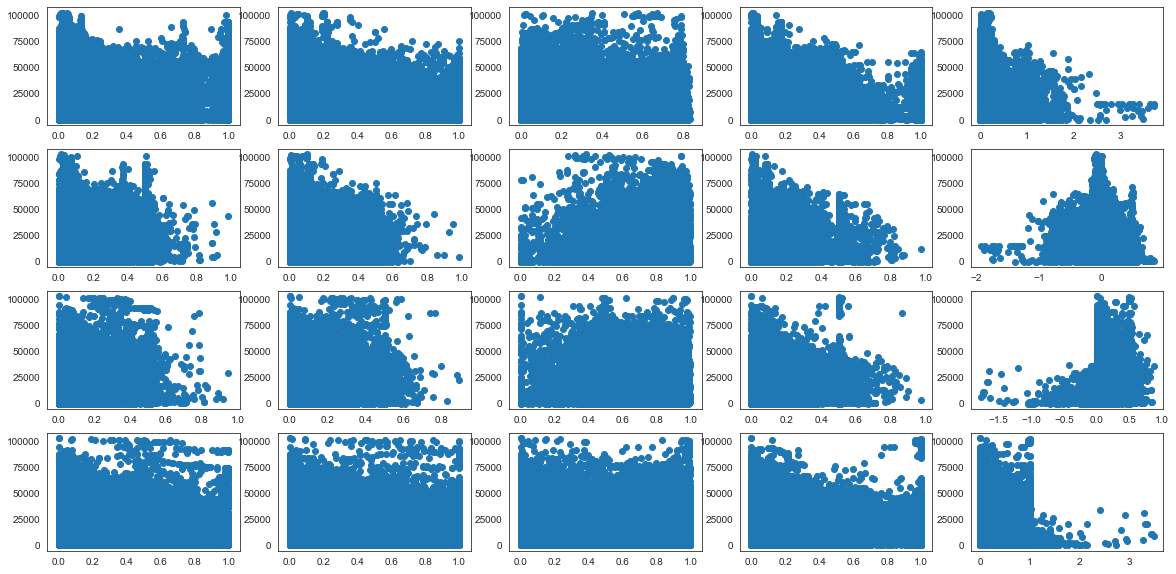

In [290]:
plt.figure(figsize=(20,10))
for i, c in enumerate(close_trainx.columns):
    plt.subplot(4,5,i+1)
    plt.scatter(OLS_df[c], OLS_df.channel_age);

In [302]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(close_trainx, close_trainy)
print('test score is: ',reg.score(close_testx, close_testy))
reg.coef_

test score is:  0.1823877417223705


array([  5452.37024162,    909.20869371,   -372.56239584,  -9236.92198554,
        -8647.29974468,  -8775.61686882,   2709.26771009,  29936.38125409,
       -11620.31239148, -21283.40505813,  64478.32828743,  28292.21339295,
       -25399.13201983, -41412.77898381,  27214.65214175, -35816.42825188,
         2987.05068744,  -1689.32111689,  10749.18387654,   3130.54917942])

In [299]:
formula2 = "channel_age ~  channel_diff_close + bet_diff_close + closeness_diff_close \
+ capacity_diff_close + growth_diff_close + channel_avg_close + bet_avg_close+ closeness_avg_close \
+ capacity_avg_close + growth_avg_close + channel_avg_open + bet_avg_open + closeness_avg_open \
+ capacity_avg_open +  growth_avg_open + channel_diff_open +  bet_diff_open +  closeness_diff_open + \
        capacity_diff_open +  growth_diff_open "
ols2 = smf.ols(formula2, data= OLS_df, missing='drop').fit()
print(ols2.summary())

                            OLS Regression Results                            
Dep. Variable:            channel_age   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     434.9
Date:                Fri, 08 May 2020   Prob (F-statistic):               0.00
Time:                        15:43:25   Log-Likelihood:            -4.2310e+05
No. Observations:               38344   AIC:                         8.462e+05
Df Residuals:                   38323   BIC:                         8.464e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             1.391e+04 

In [278]:
formula1 = "channel_age ~ channel_diff_close"
ols1 = smf.ols(formula1, data= OLS_df, missing='drop').fit()
print(ols1.summary())

                            OLS Regression Results                            
Dep. Variable:            channel_age   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     58.67
Date:                Fri, 08 May 2020   Prob (F-statistic):           1.91e-14
Time:                        15:20:10   Log-Likelihood:            -4.2699e+05
No. Observations:               38344   AIC:                         8.540e+05
Df Residuals:                   38342   BIC:                         8.540e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           1.773e+04    116

In [279]:
formula3 = "channel_age ~ channel_avg_close"
ols3 = smf.ols(formula3, data= OLS_df, missing='drop').fit()
print(ols3.summary())

                            OLS Regression Results                            
Dep. Variable:            channel_age   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     156.6
Date:                Fri, 08 May 2020   Prob (F-statistic):           7.50e-36
Time:                        15:20:31   Log-Likelihood:            -4.2694e+05
No. Observations:               38344   AIC:                         8.539e+05
Df Residuals:                   38342   BIC:                         8.539e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           1.72e+04    124.08

In [280]:
formula4 = "channel_age ~ channel_avg_close + channel_diff_close + growth_diff_close + growth_avg_close + capacity_diff_close + capacity_avg_close "
ols4 = smf.ols(formula4, data= OLS_df, missing='drop').fit()
print(ols4.summary())

                            OLS Regression Results                            
Dep. Variable:            channel_age   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     377.6
Date:                Fri, 08 May 2020   Prob (F-statistic):               0.00
Time:                        15:20:54   Log-Likelihood:            -4.2592e+05
No. Observations:               38344   AIC:                         8.519e+05
Df Residuals:                   38337   BIC:                         8.519e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             1.82e+04    

#### Regression using TPOT for channel_age

In [193]:
from tpot import TPOTRegressor

tpot = TPOTRegressor(generations=5, population_size=20, verbosity=1, scoring='r2')  # generations for optimization, pop size is models
tpot.fit(close_trainx, close_trainy.ravel())
print(tpot.score(close_testx, close_testy.ravel()))
# tpot.export('tpot_heart_pipeline.py')
# Can try again on a smaller sample of data with tqdm



TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.
Best pipeline: RandomForestRegressor(input_matrix, bootstrap=True, max_features=0.7500000000000001, min_samples_leaf=4, min_samples_split=5, n_estimators=100)
0.5347526073749463


In [195]:
tpot_best = tpot.fitted_pipeline_.steps

tpot_best[-1][1].feature_importances_

array([0.11342011, 0.06777757, 0.06505289, 0.15726155, 0.10202487,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.1037416 , 0.09382923, 0.06651351, 0.14031946, 0.09005921])

In [196]:
print(tpot_best[0][1])
tpot_best[0][1].get_feature_names()

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.7500000000000001,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)


AttributeError: 'RandomForestRegressor' object has no attribute 'get_feature_names'

In [ ]:
features = x.columns
# features_plot = features
importances = DT2.feature_importances_
idx = np.argsort(importances)
plt.title("Feature importance")
plt.barh(range(len(idx)), importances[idx])
plt.yticks(range(len(idx)), [features[i] for i in idx])
plt.ylabel("Feature")
plt.show()